# Keras starter kit [full training set, UNet]

## Setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2

import glob
import time
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from tqdm import tqdm
import cv2

# Data config
DATA_DIR = '/home/fummicc1/codes/competitions/kaggle-ink-detection'
BUFFER = 128  # Half-size of papyrus patches we'll use as model inputs
Z_DIM = 64  # Number of slices in the z direction. Max value is 64 - Z_START
Z_START = 0  # Offset of slices in the z direction
SHARED_HEIGHT = 2000  # Height to resize all papyrii

# (y, x)
val_location = (600, 500)
val_zone_size = (500, 300)

# Model config
BATCH_SIZE = 64
USE_MIXED_PRECISION = False
USE_JIT_COMPILE = False

device = torch.device("cuda")
threshold = 0.2
num_workers = 2
exp = 1e-7

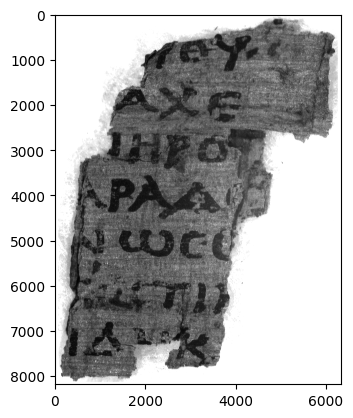

In [2]:
plt.imshow(Image.open(DATA_DIR + "/train/1/ir.png"), cmap="gray")

## Load up the training data

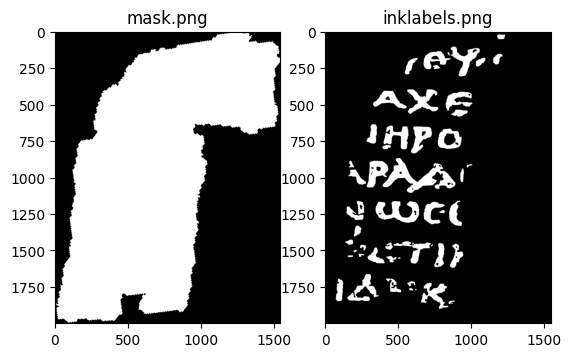

In [3]:
def resize(img):
    current_height, current_width = img.shape    
    aspect_ratio = current_width / current_height
    new_width = int(SHARED_HEIGHT * aspect_ratio)
    new_size = (new_width, SHARED_HEIGHT)
    # (W, H)の順で渡すが結果は(H, W)になっている
    img = cv2.resize(img, new_size)
    return img

def load_mask(split, index):
    img = cv2.imread(f"{DATA_DIR}/{split}/{index}/mask.png", 0) // 255
    img = resize(img)    
    return img


def load_labels(split, index):
    img = cv2.imread(f"{DATA_DIR}/{split}/{index}/inklabels.png", 0) // 255
    img = resize(img)
    return img


mask = load_mask(split="train", index=1)
labels = load_labels(split="train", index=1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(mask, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(labels, cmap='gray')
plt.show()

In [4]:
mask_test_a = load_mask(split="test", index="a")
mask_test_b = load_mask(split="test", index="b")

mask_train_1 = load_mask(split="train", index=1)
labels_train_1 = load_labels(split="train", index=1)

mask_train_2 = load_mask(split="train", index=2)
labels_train_2 = load_labels(split="train", index=2)

mask_train_3 = load_mask(split="train", index=3)
labels_train_3 = load_labels(split="train", index=3)

print(f"mask_test_a: {mask_test_a.shape}")
print(f"mask_test_b: {mask_test_b.shape}")
print("-")
print(f"mask_train_1: {mask_train_1.shape}")
print(f"labels_train_1: {labels_train_1.shape}")
print("-")
print(f"mask_train_2: {mask_train_2.shape}")
print(f"labels_train_2: {labels_train_2.shape}")
print("-")
print(f"mask_train_3: {mask_train_3.shape}")
print(f"labels_train_3: {labels_train_3.shape}")

mask_test_a: (2000, 4642)
mask_test_b: (2000, 2321)
-
mask_train_1: (2000, 1547)
labels_train_1: (2000, 1547)
-
mask_train_2: (2000, 1281)
labels_train_2: (2000, 1281)
-
mask_train_3: (2000, 1380)
labels_train_3: (2000, 1380)


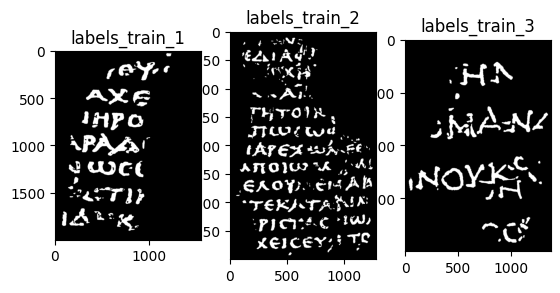

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.set_title("labels_train_1")
ax1.imshow(labels_train_1, cmap='gray')

ax2.set_title("labels_train_2")
ax2.imshow(labels_train_2, cmap='gray')

ax3.set_title("labels_train_3")
ax3.imshow(labels_train_3, cmap='gray')

plt.show()

In [6]:
def load_volume(split, index):
    # Load the 3d x-ray scan, one slice at a time
    z_slices_fnames = sorted(glob.glob(f"{DATA_DIR}/{split}/{index}/surface_volume/*.tif"))[Z_START:Z_START + Z_DIM]
    z_slices = []
    for z, filename in  tqdm(enumerate(z_slices_fnames)):
        img = cv2.imread(filename, -1)
        img = resize(img)
        z_slices.append(img)
    return np.stack(z_slices, axis=-1)

In [7]:
volume_train_1 = load_volume(split="train", index=1)
print(f"volume_train_1: {volume_train_1.shape}, {volume_train_1.dtype}")

volume_train_2 = load_volume(split="train", index=2)
print(f"volume_train_2: {volume_train_2.shape}, {volume_train_2.dtype}")

volume_train_3 = load_volume(split="train", index=3)
print(f"volume_train_3: {volume_train_3.shape}, {volume_train_3.dtype}")

volume = np.concatenate([volume_train_1, volume_train_2, volume_train_3], axis=1)
print(f"total volume: {volume.shape}")

64it [00:05, 12.15it/s]


volume_train_1: (2000, 1547, 64), uint16


64it [00:12,  5.02it/s]


volume_train_2: (2000, 1281, 64), uint16


64it [00:03, 16.04it/s]


volume_train_3: (2000, 1380, 64), uint16
total volume: (2000, 4208, 64)


In [8]:
del volume_train_1
del volume_train_2
del volume_train_3

In [9]:
labels = np.concatenate([labels_train_1, labels_train_2, labels_train_3], axis=1)
print(f"labels: {labels.shape}, {labels.dtype}")
mask = np.concatenate([mask_train_1, mask_train_2, mask_train_3], axis=1)
print(f"mask: {mask.shape}, {mask.dtype}")

labels: (2000, 4208), uint8
mask: (2000, 4208), uint8


In [10]:
# Free up memory
del labels_train_1
del labels_train_2
del labels_train_3
del mask_train_1
del mask_train_2
del mask_train_3

## Visualize the training data

In this case, not very informative. But remember to always visualize what you're training on, as a sanity check!

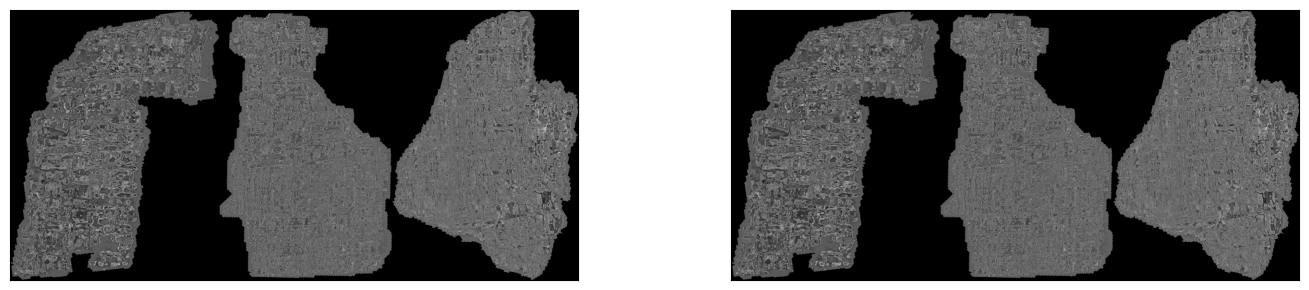

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
for z, ax in enumerate(axes):
    ax.imshow(volume[:, :, z], cmap='gray')
    ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

## Selection a validation holdout area

We set aside some fraction of the input to validate our model on.

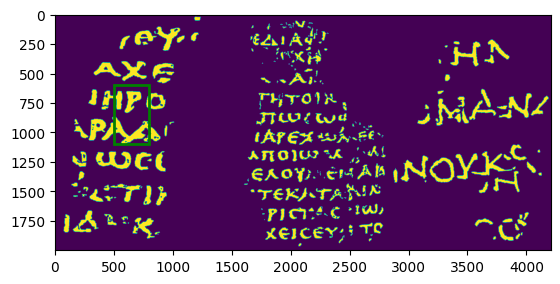

In [12]:
fig, ax = plt.subplots()
ax.imshow(labels)
patch = patches.Rectangle([val_location[1], val_location[0]], val_zone_size[1], val_zone_size[0], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(patch)
plt.show()

## Create a dataset that samples random locations in the input volume

Our training dataset will grab random patches within the masked area and outside of the validation area.

In [13]:
def sample_random_location(shape):
    random_train_x = np.random.randint(low=BUFFER, high=shape[1] - BUFFER - 1, size=())
    random_train_y = np.random.randint(low=BUFFER, high=shape[0] - BUFFER - 1, size=())
    random_train_location = np.stack([random_train_y, random_train_x], axis=-1)
    return random_train_location


def is_in_masked_zone(location, mask):
    return mask[location[0], location[1]] > 0

def is_in_val_zone(location, val_location, val_zone_size):
    x = location[1]
    y = location[0]
    x_match = val_location[1] - BUFFER <= x <= val_location[1] + val_zone_size[1] + BUFFER
    y_match = val_location[0] - BUFFER <= y <= val_location[0] + val_zone_size[0] + BUFFER
    return x_match and y_match

def is_proper_train_location(location):
    return not is_in_val_zone(location, val_location, val_zone_size) and is_in_mask_train(location)

In [14]:
sample_random_location_train = lambda x: sample_random_location(volume.shape[:-1])
is_in_mask_train = lambda x: is_in_masked_zone(x, mask)

# Create a list to store train locations
train_locations = []

# Define the number of train locations you want to generate
num_train_locations = 500

# Generate train locations
while len(train_locations) < num_train_locations:
    location = sample_random_location_train(0)
    if is_proper_train_location(location):
        train_locations.append(location)

# Convert the list of train locations to a PyTorch tensor
train_locations_ds = np.stack(train_locations, axis=0)

## Visualize some training patches

Sanity check visually that our patches are where they should be.

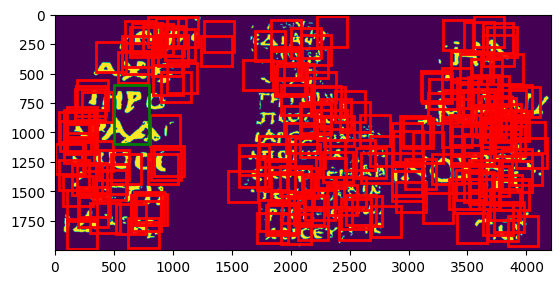

In [15]:
fig, ax = plt.subplots()
ax.imshow(labels)

# Define the number of samples you want to take from train_locations_ds
num_samples = 200

# Iterate over the first 'num_samples' elements in train_locations_ds
for i in range(num_samples):
    y, x = train_locations_ds[i]
    patch = Rectangle([x - BUFFER, y - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(patch)

val_patch = patches.Rectangle([val_location[1], val_location[0]], val_zone_size[1], val_zone_size[0], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(val_patch)
plt.show()

In [16]:
from scipy.stats import median_abs_deviation
all_MAD = median_abs_deviation(volume, axis=[0, 1])

In [17]:
all_median = np.median(volume, axis=[0, 1])

In [18]:
mean = np.mean(volume)

In [19]:
mean

15798.550203960462

In [20]:
std = np.std(volume)

In [21]:
std

13317.471485295286

In [22]:
possible_max_input = ((2 ** 16 - 1) - all_median.min()) / all_MAD.min()
possible_max_input

18.71110242376857

In [53]:
all_median

array([19576., 19582., 19597., 19609., 19616., 19626., 19638., 19642.,
       19650., 19653., 19665., 19683., 19709., 19748., 19795., 19857.,
       19945., 20054., 20184., 20347., 20563., 20834., 21153., 21523.,
       21910., 22263., 22526., 22619., 22453., 21935., 21035., 19957.,
       18981., 18246., 17804., 17672., 17848., 18266., 18839., 19476.,
       20093., 20650., 21129., 21525., 21847., 22108., 22318., 22490.,
       22630., 22746., 22841., 22923., 22992., 23051., 23099., 23138.,
       23170., 23198., 23222., 23243., 23260., 23276., 23288., 23296.])

In [54]:
all_MAD

array([12430., 12460., 12490., 12522., 12562., 12605., 12642., 12679.,
       12711., 12753., 12794., 12832., 12866., 12890., 12919., 12942.,
       12956., 12974., 13013., 13059., 13100., 13154., 13245., 13367.,
       13545., 13779., 14049., 14339., 14602., 14803., 14875., 14564.,
       13634., 12099., 10137.,  8517.,  7498.,  6681.,  5969.,  5349.,
        4829.,  4401.,  4055.,  3787.,  3577.,  3408.,  3272.,  3159.,
        3065.,  2986.,  2920.,  2862.,  2809.,  2762.,  2723.,  2692.,
        2667.,  2644.,  2623.,  2604.,  2589.,  2575.,  2564.,  2558.])

In [25]:
printed = False

def extract_subvolume(location, volume):
    global printed
    # print(np.unique(volume, return_counts=True, return_index=True))
    x = location[0]
    y = location[1]
    subvolume = volume[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER, :].astype(np.float32)
    # print("subvolume[:, :, 0]", subvolume[:, :, 0])
    median = np.full_like(subvolume, all_median).astype(np.float32)
    MAD = np.full_like(subvolume, all_MAD).astype(np.float32)
    # mean = np.mean(subvolume, axis=2)
    # mean = np.stack([mean for i in range(Z_DIM)], axis=2) + exp
    # MAD = median_abs_deviation(subvolume, axis=2)
    # print("MAD", MAD[0, 0, :])
    # print("mean", mean)
    # print("median", median[0, 0, :])
    
    subvolume = (subvolume - median) / MAD
    
    if not printed:
        print("subvolume after taking care of median and MAD", subvolume)
        printed = True
    
    return subvolume

## Create training dataset that yields random subvolumes and their labels

In [26]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder

class SubvolumeDataset(Dataset):
    def __init__(self, locations, volume, labels, buffer, is_train: bool, return_location: bool = False):
        self.locations = locations
        self.volume = volume
        self.labels = labels        
        self.buffer = buffer
        self.is_train = is_train
        self.return_location = return_location

    def __len__(self):
        return len(self.locations)

    def __getitem__(self, idx):
        label = None
        location = np.array(self.locations[idx])
        y, x = location[0], location[1]

        subvolume = extract_subvolume(location, self.volume)        
        # print("subvolume", subvolume)
        # print("labels", labels)
        # subvolume = subvolume.numpy()
        subvolume = subvolume
        
        if self.labels is not None:
            label = self.labels[y - self.buffer:y + self.buffer, x - self.buffer:x + self.buffer]
            # print("label", label)
            # n_category = 2
            # label = np.eye(n_category)[label]
            label = np.stack([label], axis=-1)
            # label = label.numpy()
            # print("label.shape", label.shape
        
        if self.is_train and label is not None:            
            
            # print("label", label.dtype)
            # print("subvolume in dataset (before aug)", subvolume)            
            # performed = A.Compose([            
            #     A.ToFloat(max_value=possible_max_input),
            #     # A.RandomBrightnessContrast(),
            #     # A.HorizontalFlip(),
            #     # A.VerticalFlip(),  
            #     # A.Normalize(
            #     #     mean=[mean],
            #     #     std=[std],
            #     # ),
            #     A.FromFloat(max_value=possible_max_input),
            # ])(image=subvolume, mask=label)
            # subvolume = performed["image"]            
            # label = performed["mask"]
            # print("subvolume in dataset (after aug)", subvolume)
            # print("label", label.dtype)
            # print("subvolume", subvolume.dtype)
            # →C, H, W
            subvolume = torch.from_numpy(subvolume.transpose(2, 0, 1).astype(np.float64))
            # print(performed)
            # print(subvolume.shape, label.shape)
            # H, W, C → C, H, W
            label = torch.from_numpy(label.transpose(2, 0, 1).astype(np.uint8)) 
        else:            
            # performed = A.Compose([  
            #     A.ToFloat(max_value=possible_max_input),                
            #     # A.Normalize(
            #     #     mean=[mean],
            #     #     std=[std],
            #     # ),
            #     A.FromFloat(max_value=possible_max_input),
            # ])(image=subvolume)
            # subvolume = performed["image"]
            subvolume = torch.from_numpy(subvolume.transpose(2, 0, 1).astype(np.float64))
            if label is not None:
                label = torch.from_numpy(label.transpose(2, 0, 1).astype(np.uint8)) 
        if self.return_location:
            return subvolume, location
        return subvolume, label        

In [27]:

# Convert train_locations_ds to a PyTorch tensor
train_locations_tensor = np.stack([x for x in train_locations_ds], axis=0)

# Create an instance of the SubvolumeDataset
train_ds = SubvolumeDataset(train_locations_tensor, volume, labels, BUFFER, is_train=True)


In [28]:
# Create a DataLoader with the dataset
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)

In [29]:
subvolume_batch, label_batch = train_ds[1]
print(f"subvolume shape: {subvolume_batch.shape}")
print(f"label_batch shape: {label_batch.shape}")

subvolume after taking care of median and MAD [[[ 0.5526146   0.5858748   0.59423536 ...  1.3005825   1.24883
    1.213057  ]
  [ 0.81842315  1.0329856   1.1264211  ...  1.0104854   0.9843994
    0.8663018 ]
  [ 1.1855993   1.2077047   1.1761409  ...  0.68271846  0.65912634
    0.6939015 ]
  ...
  [-0.21697506  0.10826645  0.34051242 ...  0.8924272   0.96372855
    0.92337763]
  [ 0.8258246   0.82576245  0.76717377 ...  0.83456314  1.0097504
    1.202502  ]
  [ 1.130732    1.09687     0.9581265  ...  0.6691262   0.89079565
    1.1059421 ]]

 [[ 1.2803701   1.117175    0.8701361  ...  1.1879612   1.3190328
    1.297498  ]
  [ 0.8570394   0.9132424   0.9054444  ...  1.1716505   1.1926677
    1.1196247 ]
  [ 0.81078035  0.72038525  0.62890315 ...  0.54679614  0.4777691
    0.5039093 ]
  ...
  [-0.07433628  0.25754413  0.59319454 ...  1.6209708   1.8634945
    1.9429241 ]
  [ 0.622848    0.6535313   0.6843875  ...  1.8539805   1.9687988
    1.9636434 ]
  [ 0.5324216   0.5349117   0.5450761

## Check dataset throughput

It's always a good idea to check that your data pipeline is efficient. You don't want to be CPU-bound at training time!

In [30]:
# t0 = time.time()
# n = 200
# for _ in train_ds:
#     pass
# print(f"Time per batch: {(time.time() - t0) / n:.4f}s")

## Create validation dataset

In [31]:
val_locations_stride = BUFFER
val_locations = []
for x in range(val_location[0], val_location[0] + val_zone_size[0], val_locations_stride):
    for y in range(val_location[1], val_location[1] + val_zone_size[1], val_locations_stride):
        val_locations.append((x, y))

# Convert the list of val locations to a PyTorch tensor
val_locations_ds = np.stack(val_locations, axis=0)

# Create an instance of the SubvolumeDataset
val_ds = SubvolumeDataset(val_locations_ds, volume, labels, BUFFER, is_train=False)

# Create a DataLoader with the dataset
val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)


## Visualize validation dataset patches

Note that they are partially overlapping, since the stride is half the patch size.

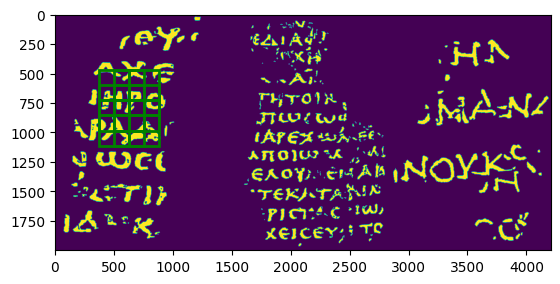

In [32]:
fig, ax = plt.subplots()
ax.imshow(labels)

for y, x in val_locations_ds:
    patch = patches.Rectangle([x - BUFFER, y - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(patch)
plt.show()

## Compute a trivial baseline

This is the highest validation score you can reach without looking at the inputs.
The model can be considered to have statistical power only if it can beat this baseline.

In [33]:
def trivial_baseline(dataset):
    total = 0
    matches = 0.
    for _, batch_label in tqdm(dataset):
        batch_label = torch.tensor(batch_label)
        matches += torch.sum(batch_label.float())
        total += torch.numel(batch_label)
    return 1. - matches / total

score = trivial_baseline(val_ds).item()
print(f"Best validation score achievable trivially: {score * 100:.2f}% accuracy")

  0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_2656299/1352218617.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_label = torch.tensor(batch_label)
100%|██████████| 12/12 [00:00<00:00, 87.44it/s]

Best validation score achievable trivially: 70.01% accuracy


## Augment the training data

## Train a Keras model

This model is a U-Net taken from [this segmentation tutorial](https://keras.io/examples/vision/oxford_pets_image_segmentation/).

`model.fit()` goes brrrrr

Conceptually it looks like this (animation from [this tutorial](https://www.kaggle.com/code/jpposma/vesuvius-challenge-ink-detection-tutorial)):

![animation](https://user-images.githubusercontent.com/22727759/224853385-ed190d89-f466-469c-82a9-499881759d57.gif)

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy

In [35]:

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(                
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            )

        def transpose_conv_block(in_channels, out_channels):
            return nn.Sequential(                
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            )

        self.encoder = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels if i == 2 else 64 * 2**(i - 1), 64 * 2**i, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(64 * 2**i),
                nn.ReLU(),
                nn.Conv2d(64 * 2**i, 64 * 2**i, kernel_size=3, padding=1),
                nn.BatchNorm2d(64 * 2**i),
                nn.ReLU(),
            )
            for i in range(2, 4)
        ])


        self.middle = nn.Sequential(
            conv_block(512, 512),
            conv_block(512, 512),
        )
        
        self.decoder = nn.ModuleList([
            nn.Sequential(
                transpose_conv_block(2 ** (i + 7), 2 ** (i + 6)),
                transpose_conv_block(2 ** (i + 6), 2 ** (i + 5)),
                nn.Upsample(scale_factor=2, mode="nearest"),
            )
            for i in range(3, 1, -1)
        ])
        self.final_decoder = nn.Sequential(
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.Conv2d(32, out_channels, kernel_size=3, padding=1),
        )
        self.activation = nn.Identity()

    def forward(self, x):
        # print("input:", x)
        skip_connections = []
        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)

        x = self.middle(x)
        
        # print("encoder ok", x)
        for i, layer in enumerate(self.decoder):            
            # print(f"decoder will {i}: ok", x.shape)
            x = torch.cat([x, skip_connections[-i-1]], dim=1)  # Concatenate along channel dimension
            # print(f"decoder with skip connection {i}: ok", x.shape)            
            x = layer(x)            
            # print(f"decoder {i}: ok", x)
        # print("decoder ok")
        x = self.final_decoder(x)
        x = self.activation(x)
        # print("final out", x)
        return x

In [36]:
import os
import torch.optim.lr_scheduler

# Define the model
model = UNet(Z_DIM, 2)
model = nn.DataParallel(model)

if os.path.exists(f"{DATA_DIR}/model.pt"):
    # model.load_state_dict(torch.load(f"{DATA_DIR}/model.pt"))
    pass

# Mixed precision training
# scaler = torch.cuda.amp.GradScaler(enabled=USE_MIXED_PRECISION)

# Training loop
num_epochs = 30

# Loss, optimizer, and metric
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
accuracy = Accuracy(task="multiclass", num_classes=2, top_k=1).to(device)

In [37]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for idx, (subvolumes, labels) in tqdm(enumerate(train_dataloader)):
        subvolumes, labels = subvolumes.to(device), labels.to(device)        
        labels = labels.long().squeeze(dim=1)
        subvolumes = subvolumes.float() 
        
        # print("torch.unique(subvolumes)", torch.unique(subvolumes), file=open("subvolumes_unique", "w"))

        optimizer.zero_grad()

        outputs = model(subvolumes)
        # print("outputs", outputs)
        # print("outputs", outputs.shape, "labels", labels.shape)
        loss = criterion(outputs, labels)  
        acc = accuracy(outputs, labels)

        loss.backward()
        optimizer.step()    

        running_loss += loss.item()
        running_accuracy += acc
        
    # print("train output", outputs)
        
    scheduler.step()    
        
    running_loss /= len(train_dataloader)
    running_accuracy /= len(train_dataloader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for subvolumes, labels in tqdm(val_dataloader):
            subvolumes, labels = subvolumes.to(device), labels.to(device)
            labels = labels.long().squeeze(dim=1)
            subvolumes = subvolumes.float()
            outputs = model(subvolumes)
            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)

            val_loss += loss.item()
            val_accuracy += acc    
            
        # print("val outputs", outputs)

    val_loss /= len(val_dataloader)
    val_accuracy /= len(val_dataloader)

    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss:.4f} Accuracy: {running_accuracy:.4f} Val_Loss: {val_loss:.4f} Val_Accuracy: {val_accuracy:.4f}")

    running_loss = 0.0
    running_accuracy = 0.0
    model.train()

    if epoch % 10 == 0:
        torch.save(model.state_dict(), "model.pt")

8it [00:11,  1.41s/it][00:00<?, ?it/s]
  3%|▎         | 1/30 [00:12<05:57, 12.33s/it]

Epoch [1/30] Loss: 0.4725 Accuracy: 0.8049 Val_Loss: 0.6415 Val_Accuracy: 0.7001


8it [00:09,  1.17s/it]
  7%|▋         | 2/30 [00:22<05:12, 11.17s/it]

Epoch [2/30] Loss: 0.4090 Accuracy: 0.8515 Val_Loss: 0.8197 Val_Accuracy: 0.7001


8it [00:09,  1.17s/it]
 10%|█         | 3/30 [00:33<04:51, 10.79s/it]

Epoch [3/30] Loss: 0.3961 Accuracy: 0.8516 Val_Loss: 0.6607 Val_Accuracy: 0.7001


8it [00:09,  1.17s/it]
 13%|█▎        | 4/30 [00:43<04:36, 10.64s/it]

Epoch [4/30] Loss: 0.3918 Accuracy: 0.8520 Val_Loss: 0.6883 Val_Accuracy: 0.7001


8it [00:09,  1.17s/it]
 17%|█▋        | 5/30 [00:53<04:23, 10.55s/it]

Epoch [5/30] Loss: 0.3878 Accuracy: 0.8520 Val_Loss: 0.5941 Val_Accuracy: 0.7001


8it [00:09,  1.17s/it]
 20%|██        | 6/30 [01:04<04:12, 10.50s/it]

Epoch [6/30] Loss: 0.3848 Accuracy: 0.8519 Val_Loss: 0.6791 Val_Accuracy: 0.7001


8it [00:09,  1.18s/it]
 23%|██▎       | 7/30 [01:14<04:00, 10.48s/it]

Epoch [7/30] Loss: 0.3781 Accuracy: 0.8518 Val_Loss: 0.6303 Val_Accuracy: 0.7001


8it [00:09,  1.18s/it]
 27%|██▋       | 8/30 [01:25<03:50, 10.46s/it]

Epoch [8/30] Loss: 0.3760 Accuracy: 0.8518 Val_Loss: 0.6640 Val_Accuracy: 0.7001


8it [00:09,  1.16s/it]
 30%|███       | 9/30 [01:35<03:38, 10.42s/it]

Epoch [9/30] Loss: 0.3766 Accuracy: 0.8513 Val_Loss: 0.6208 Val_Accuracy: 0.7001


8it [00:09,  1.17s/it]
 33%|███▎      | 10/30 [01:45<03:28, 10.41s/it]

Epoch [10/30] Loss: 0.3703 Accuracy: 0.8519 Val_Loss: 0.6026 Val_Accuracy: 0.7001


8it [00:09,  1.17s/it]
 37%|███▋      | 11/30 [01:56<03:17, 10.41s/it]

Epoch [11/30] Loss: 0.3679 Accuracy: 0.8520 Val_Loss: 0.6441 Val_Accuracy: 0.7001


8it [00:09,  1.17s/it]
 40%|████      | 12/30 [02:06<03:07, 10.41s/it]

Epoch [12/30] Loss: 0.3653 Accuracy: 0.8519 Val_Loss: 0.6075 Val_Accuracy: 0.7001


8it [00:09,  1.18s/it]
 43%|████▎     | 13/30 [02:17<02:57, 10.41s/it]

Epoch [13/30] Loss: 0.3644 Accuracy: 0.8516 Val_Loss: 0.6266 Val_Accuracy: 0.7001


8it [00:09,  1.18s/it]
 47%|████▋     | 14/30 [02:27<02:46, 10.42s/it]

Epoch [14/30] Loss: 0.3598 Accuracy: 0.8520 Val_Loss: 0.6863 Val_Accuracy: 0.7001


8it [00:09,  1.18s/it]
 50%|█████     | 15/30 [02:38<02:36, 10.46s/it]

Epoch [15/30] Loss: 0.3582 Accuracy: 0.8522 Val_Loss: 0.6849 Val_Accuracy: 0.7001


8it [00:09,  1.18s/it]
 53%|█████▎    | 16/30 [02:48<02:26, 10.47s/it]

Epoch [16/30] Loss: 0.3529 Accuracy: 0.8522 Val_Loss: 0.6706 Val_Accuracy: 0.7001


8it [00:09,  1.19s/it]
 57%|█████▋    | 17/30 [02:59<02:16, 10.49s/it]

Epoch [17/30] Loss: 0.3492 Accuracy: 0.8520 Val_Loss: 0.6561 Val_Accuracy: 0.7001


8it [00:09,  1.18s/it]
 60%|██████    | 18/30 [03:09<02:05, 10.48s/it]

Epoch [18/30] Loss: 0.3465 Accuracy: 0.8520 Val_Loss: 0.6862 Val_Accuracy: 0.7001


8it [00:09,  1.18s/it]
 63%|██████▎   | 19/30 [03:20<01:55, 10.48s/it]

Epoch [19/30] Loss: 0.3395 Accuracy: 0.8519 Val_Loss: 0.7134 Val_Accuracy: 0.7001


8it [00:09,  1.18s/it]
 67%|██████▋   | 20/30 [03:30<01:44, 10.49s/it]

Epoch [20/30] Loss: 0.3364 Accuracy: 0.8519 Val_Loss: 0.6561 Val_Accuracy: 0.7001


8it [00:09,  1.19s/it]
 70%|███████   | 21/30 [03:41<01:34, 10.52s/it]

Epoch [21/30] Loss: 0.3335 Accuracy: 0.8519 Val_Loss: 0.6667 Val_Accuracy: 0.7001


8it [00:09,  1.18s/it]
 73%|███████▎  | 22/30 [03:51<01:24, 10.50s/it]

Epoch [22/30] Loss: 0.3336 Accuracy: 0.8520 Val_Loss: 0.7776 Val_Accuracy: 0.7001


8it [00:09,  1.18s/it]
 77%|███████▋  | 23/30 [04:02<01:13, 10.50s/it]

Epoch [23/30] Loss: 0.3270 Accuracy: 0.8519 Val_Loss: 0.7137 Val_Accuracy: 0.7001


8it [00:09,  1.20s/it]
 80%|████████  | 24/30 [04:12<01:03, 10.54s/it]

Epoch [24/30] Loss: 0.3228 Accuracy: 0.8516 Val_Loss: 0.6462 Val_Accuracy: 0.7001


8it [00:09,  1.18s/it]
 83%|████████▎ | 25/30 [04:23<00:52, 10.52s/it]

Epoch [25/30] Loss: 0.3231 Accuracy: 0.8521 Val_Loss: 0.6282 Val_Accuracy: 0.7001


8it [00:09,  1.18s/it]
 87%|████████▋ | 26/30 [04:33<00:42, 10.51s/it]

Epoch [26/30] Loss: 0.3186 Accuracy: 0.8518 Val_Loss: 0.6490 Val_Accuracy: 0.7001


8it [00:09,  1.18s/it]
 90%|█████████ | 27/30 [04:44<00:31, 10.50s/it]

Epoch [27/30] Loss: 0.3114 Accuracy: 0.8522 Val_Loss: 0.6792 Val_Accuracy: 0.7001


8it [00:09,  1.18s/it]
 93%|█████████▎| 28/30 [04:54<00:21, 10.51s/it]

Epoch [28/30] Loss: 0.3114 Accuracy: 0.8520 Val_Loss: 0.6664 Val_Accuracy: 0.7001


8it [00:09,  1.18s/it]
 97%|█████████▋| 29/30 [05:05<00:10, 10.51s/it]

Epoch [29/30] Loss: 0.3175 Accuracy: 0.8518 Val_Loss: 0.6819 Val_Accuracy: 0.7001


8it [00:09,  1.19s/it]
100%|██████████| 30/30 [05:15<00:00, 10.52s/it]

Epoch [30/30] Loss: 0.3083 Accuracy: 0.8518 Val_Loss: 0.6875 Val_Accuracy: 0.7001


## Clear up memory

In [38]:
del volume
del mask
del labels
del train_ds
del val_ds

import gc
gc.collect()

0

In [39]:
model = UNet(Z_DIM, 2)
model = nn.DataParallel(model)
model.load_state_dict(torch.load("model.pt"))
model = model.to(device)

## Compute predictions on test data

In [40]:
a = np.arange(10)
a[:6][:]

array([0, 1, 2, 3, 4, 5])

In [41]:

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm

def compute_predictions_map(split, index):
    
    print(f"Load data for {split}/{index}")

    test_volume = load_volume(split=split, index=index)
    test_mask = load_mask(split=split, index=index)    

    test_locations = []
    stride = BUFFER // 2
    for y in range(BUFFER, test_volume.shape[0] - BUFFER, stride):
        for x in range(BUFFER, test_volume.shape[1] - BUFFER, stride):
            test_locations.append((y, x))

    print(f"{len(test_locations)} test locations (before filtering by mask)")

    # filter locations inside the mask
    test_locations = [loc for loc in test_locations if is_in_masked_zone(loc, test_mask)]
    
    print(f"{len(test_locations)} test locations (after filtering by mask)")

    test_ds = SubvolumeDataset(test_locations, test_volume, None, BUFFER, is_train=False, return_location=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=num_workers)

    # shape: (X, Y, C)
    predictions_map = np.zeros_like(test_volume[:, :, 0]).transpose((1, 0))[:, :, np.newaxis].astype(np.float64)
    
    print("test_volume.shape", test_volume.shape)
    print("predictions_map.shape", predictions_map.shape)

    print(f"Compute predictions")

    model.eval()  # set model to evaluation mode
    with torch.no_grad():    
        for patch_batch, loc_batch in tqdm(test_loader):
            loc_batch = loc_batch.to(device).long()
            patch_batch = patch_batch.to(device).float()
            predictions = model(patch_batch)
            # print("predictions", predictions)
            predictions = nn.Softmax(dim=1)(predictions)
            predictions: torch.Tensor = predictions[:, 1, :, :].unsqueeze(dim=1)
            # print("Softmaxed predictions where conf is gt threshold", predictions[predictions.gt(threshold)])
            # →(BATCH, W, H, C)
            predictions = torch.permute(predictions, (0, 3, 2, 1))
            predictions = predictions.cpu().numpy()  # move predictions to cpu and convert to numpy
            for (y, x), pred in zip(loc_batch, predictions):
                # print("index: ", index ,"x, y, pred", x.item(), y.item(), pred[BUFFER, BUFFER, :].item(), file=open('log.out', 'a'))
                predictions_map[
                    x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :
                ][pred > threshold] = 1
    print("predictions_map", predictions_map, file=open("predictions_map", "w"))
    return predictions_map


In [42]:
from skimage.transform import resize as resize_ski
import pathlib

In [43]:
def rle(predictions_map, threshold):
    flat_img = (np.where(predictions_map.flatten() >= threshold, 1, 0)).astype(np.uint8)
    
    # Add padding at the beginning and end
    flat_img = np.pad(flat_img, pad_width=1, mode='constant', constant_values=0)

    starts = np.where((flat_img[:-1] == 0) & (flat_img[1:] == 1))[0]
    ends = np.where((flat_img[:-1] == 1) & (flat_img[1:] == 0))[0]

    lengths = ends - starts
    
    print(lengths.shape)

    return " ".join(map(str, np.c_[starts, lengths].flatten()))


In [44]:
def update_submission(predictions_map, index):
    rle_ = rle(predictions_map, threshold=threshold)
    print(f"{index}," + rle_, file=open('submission.csv', 'a'))

## Resize prediction maps to their original size (for submission)

In [52]:
print("Id,Predicted", file=open('submission.csv', 'w'))
folder = pathlib.Path(DATA_DIR) / "test"
for p in list(folder.iterdir()):
    index = p.stem
    predictions_map = compute_predictions_map(split="test", index=index)
    original_size = cv2.imread(DATA_DIR + f"/test/{index}/mask.png", 0).shape[:2]
    # W, H, C → H, W, C
    predictions_map = predictions_map.transpose((1, 0, 2))    
    predictions_map = resize_ski(predictions_map, (original_size[0], original_size[1], 1)).squeeze(axis=-1)    
    print("original predictions_map size", predictions_map.shape)    
    # H, W → W, H
    update_submission(predictions_map.transpose((1, 0)), index)
    break

Load data for test/a


64it [00:02, 31.68it/s]


1932 test locations (before filtering by mask)
1315 test locations (after filtering by mask)
test_volume.shape (2000, 4642, 64)
predictions_map.shape (4642, 2000, 1)
Compute predictions


100%|██████████| 21/21 [00:22<00:00,  1.07s/it]


original predictions_map size (2727, 6330)
(27335,)


In [46]:
predictions_map.shape, predictions_map.shape

((14830, 9506), (14830, 9506))

In [47]:
predictions_map

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

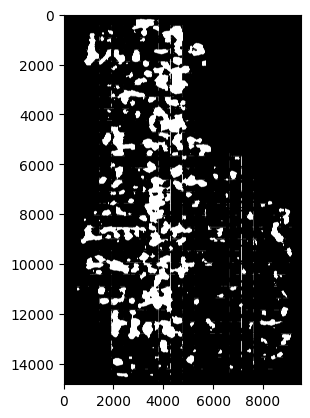

In [48]:
plt.imshow(predictions_map, cmap="gray")
predictions_map == 1